We can use the logistic model in estimating the size and the peak time of the coronavirus epidemic in Philippines. Logistic model uses a logistic function.

A logistic function or logistic curve is a common S-shaped curve (sigmoid curve) with equation

$f(x)={\frac {L}{1+e^{-k(x-x_{0})}}}$

where

*e* = the natural logarithm base (also known as Euler's number)

*$x_{0}$* = the x value of the sigmoid's midpoint,

*L* = the curve's maximum value,

*k* = the logistic growth rate or steepness of the curve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy import optimize
from datetime import datetime, timedelta

import matplotlib.dates as mdates


tab10 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', 
         '#8C564B', '#CFECF9', '#7F7F7F', '#BCBD22', '#17BECF']

%matplotlib inline

In [2]:
#### Get the data
df = pd.read_csv('ph_covid19_daily_data.csv')
df = df.fillna(0)
df.head(3)

,date,total_cases,new_cases,new_death,total_death,new_recovered,total_recovered,total_active_case
0,2020-01-29,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2020-01-31,1.0,0.0,0.0,0.0,0.0,0.0,0


In [3]:
#### Plot the data
def plot_result(raw_data, label = "Confirmed Cases", **kwargs):
    
    predicted = kwargs.get('predicted', None)
    
    if predicted is not None:
        interval = len(predicted) // 10
    else:
        interval = len(raw_data) // 10

    day_loc = mdates.DayLocator(interval=interval)  # every day
    date_fmt = mdates.DateFormatter('%Y-%m-%d')

    fig, ax = plt.subplots()
    
    fig.suptitle(label)
    
    ax.scatter(raw_data.index, raw_data.values, label='Actual')
    
    if predicted is not None:
        ax.plot(predicted.index, predicted.values, '--r', label='Fitted')
    

    # format the ticks
    ax.xaxis.set_major_locator(day_loc)
    ax.xaxis.set_major_formatter(date_fmt)
    
    #ax.set_xlim(date_min, date_max)

    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(False)

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
    
    ax.legend()
    #plt.legend(['Actual','Fitted'])
        
#### Curve fitting using logistic function
def log_curve(x, k, x_0, ymax):
    return ymax / (1 + np.exp(-k*(x-x_0)))

In [4]:
#### Process the data, since day with 100th confirmed case
df.date = pd.to_datetime(df.date)

ph_total_cases = df[(df.total_cases > 0) & (df.date >= "2020-03-14") ].total_cases.to_list()
#ph_date = df[(df.total_cases > 0)].date.dt.strftime('%Y-%m-%d').to_list()
#date_forecast = pd.date_range(, periods=100).to_pydatetime().tolist()
#date_forecast = np.array(pd.date_range("2020-04-10", periods=30).strftime('%Y-%m-%d').tolist())

ph_date = df[(df.total_cases > 0) & (df.date >= "2020-03-14")].date.to_list()
last_reported_ph_date = ph_date[-1]

#ph_date_forecast = pd.date_range(datetime.today().strftime("%Y-%m-%d"), periods=30).tolist()
ph_date_forecast = pd.date_range(last_reported_ph_date + timedelta(days=1), periods=30).tolist()

y_ph_total_cases = np.array(ph_total_cases)
x_ph_total_cases = np.arange(0, len(y_ph_total_cases))

x_ph_date = np.array(ph_date)
x_ph_date_forecast = np.array(ph_date_forecast)

In [5]:
df[(df.total_cases > 0) & (df.date >= "2020-03-14")].head(3)

,date,total_cases,new_cases,new_death,total_death,new_recovered,total_recovered,total_active_case
45,2020-03-14,111.0,13.0,2.0,0.0,0.0,0.0,111
46,2020-03-15,140.0,29.0,3.0,12.0,2.0,2.0,126
47,2020-03-16,142.0,2.0,0.0,12.0,1.0,3.0,127


In [6]:
df[(df.total_cases > 0) & (df.date >= "2020-03-14")].tail(3)

,date,total_cases,new_cases,new_death,total_death,new_recovered,total_recovered,total_active_case
81,2020-04-19,6259.0,172.0,12.0,409.0,56.0,572.0,"5,278"
82,2020-04-20,6459.0,200.0,19.0,428.0,41.0,613.0,"5,418"
83,2020-04-21,6599.0,140.0,9.0,437.0,41.0,654.0,"5,508"


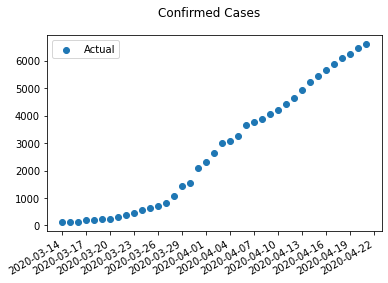

In [7]:
#### Plot the confirmed cases
confirmed_cases = pd.Series(y_ph_total_cases, index=x_ph_date)
plot_result(confirmed_cases, 'Confirmed Cases')



In [8]:
#### Fit the curve
params, params_covariance = optimize.curve_fit(log_curve, x_ph_total_cases, y_ph_total_cases, 
                                               bounds=([0,0,0],np.inf), maxfev=10000)
estimated_k, estimated_x_0, ymax = params

print(params)

[1.63540027e-01 2.32148479e+01 6.88716703e+03]


In [9]:
#### Plot the fitted curve
k = estimated_k
x_0 = estimated_x_0

x_fitted = np.arange(0, len(y_ph_total_cases) + 30)
y_fitted = log_curve(x_fitted, k, x_0, ymax)

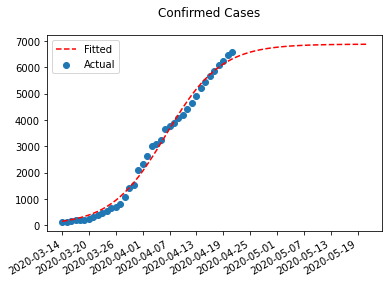

In [10]:
x_label = np.append(x_ph_date, x_ph_date_forecast, axis=0)

forecast_cases = pd.Series(y_fitted, index=x_label)
plot_result(confirmed_cases, 'Confirmed Cases', predicted=forecast_cases)

In [11]:
forecast_cases.tail()

2020-05-17    6878.442466
2020-05-18    6879.757303
2020-05-19    6880.874169
2020-05-20    6881.822821
2020-05-21    6882.628557
dtype: float64